<a href="https://colab.research.google.com/github/RichardXiao13/Google_Code_In/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoder**
In machine learning, an autoencoder is a type of neural network. The structure of an autoencoder can be defined simply as an encoder which passes information to the bottleneck which is then passed into the decoder for reconstruction. An encoder is just a network that converts the input features into smaller, denser representations. The bottleneck is simply the last layer of the encoder which holds the smallest representations of the input data. The decoder can be described as the opposite of the encoder. Where the encoder takes input features and converts them to denser parts, the decoder takes the denser features and reconstructs the inputs. Below is a visual representation from [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder).

![alt text](https://drive.google.com/uc?id=1K7Np2Gk9BdgPizQsKjN7_gR5pUEuBN3s)

In many cases, autoencoders are used for removing noise from the inputs. This task is done by learning to seperate the noise and keeping the important features in the encoder while reconstructing those features without the noise in the decoder. This notebook is a great example of this problem.

# **Task**
Autoencoders can vary in size and complexity depending on the task. This notebook is designed to be a brief introduction to a much larger subset of autoencoders. For this reason, we will build a simple autoencoder which takes in a greyscaled image with noise and tries to reconstruct the original image without the noise. We can use the MNIST dataset for this exact purpose.

# **Setup**
To begin, we will load in Tensorflow and import the required modules for building our autoencoder.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


Use tensorflow's functional API.

In [0]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# **Encoder**
Here, we will build the encoder portion of the autoencoder. We will use an input layer that takes in features of shape `(28, 28, 1)` because the Fashion MNIST dataset contains images that are 28 x 28 and grayscaled. Next, we will create three convolutional blocks which reduce the image width and height by two at each block. Notice that the last layer in our encoder is the bottleneck which contains the densest representations of our input features.

In [0]:
input_image = layers.Input(shape=(28, 28, 1))
layer = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(input_image)
layer = layers.Dropout(0.4)(layer)
layer = layers.Conv2D(16, (3, 3), padding="same", activation="relu")(layer)
layer = layers.MaxPooling2D((2, 2), padding="same")(layer)
layer = layers.Conv2D(16, (3, 3), padding="same", activation="relu")(layer)
layer = layers.MaxPooling2D((2, 2), padding="same")(layer)
layer = layers.Conv2D(16, (3, 3), padding="same", activation="relu")(layer)
layer = layers.Dropout(0.4)(layer)
layer = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(layer)
encode = layers.MaxPooling2D((2, 2), padding="same")(layer)

# **Decoder**
Since we described above that the decoder is simply the opposite of the encoder, we will construct it accordingly. We include three convolutional blocks where the images get scaled up by two in their width and height. Now, the last layer of our decoder will be the image that is reconstructed. We specify one filter as this represents the single channel images we input.

In [0]:
layer = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(encode)
layer = layers.Dropout(0.4)(layer)
layer = layers.Conv2D(16, (3, 3), padding="same", activation="relu")(layer)
layer = layers.UpSampling2D((2, 2))(layer)
layer = layers.Conv2D(16, (3, 3), padding="same", activation="relu")(layer)
layer = layers.UpSampling2D((2, 2))(layer)
layer = layers.Conv2D(16, (3, 3),padding="same", activation="relu")(layer)
layer = layers.Dropout(0.4)(layer)
layer = layers.Conv2D(32, (3, 3), activation="relu")(layer)
layer = layers.UpSampling2D((2, 2))(layer)
decode = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(layer)

# **Compile the Autoencoder**

In [0]:
autoencoder = keras.models.Model(input_image, decode)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# **MNIST Dataset**
Now that we have built our model, we can import the mnist dataset and run training.

In [0]:
from tensorflow.keras.datasets import mnist

Here, we load the dataset into a training and validation set.

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


We have to do some preprocessing before we can use our images for training. First, we have to normalize the pixels so that the values of the pixels are between 0 and 1.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def add_noise(image):
  height, width = image.shape
  mean = 0.0
  var = 0.3
  sigma = var**0.5
  gauss = np.random.normal(mean, sigma, (height, width))
  apply_noise = image + gauss
  return apply_noise

In [0]:
x_noise = np.copy(x_train)
x_noise_test = np.copy(x_test)

def noisy_images(images):
  for i, image in enumerate(images):
    images[i] = add_noise(image)

noisy_images(x_noise)
noisy_images(x_noise_test)

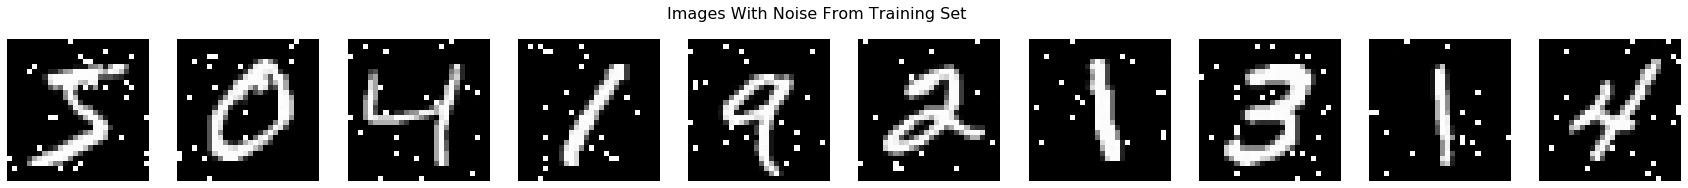

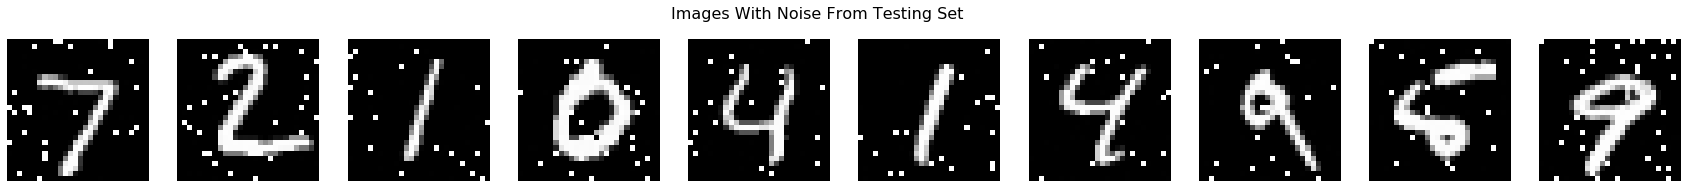

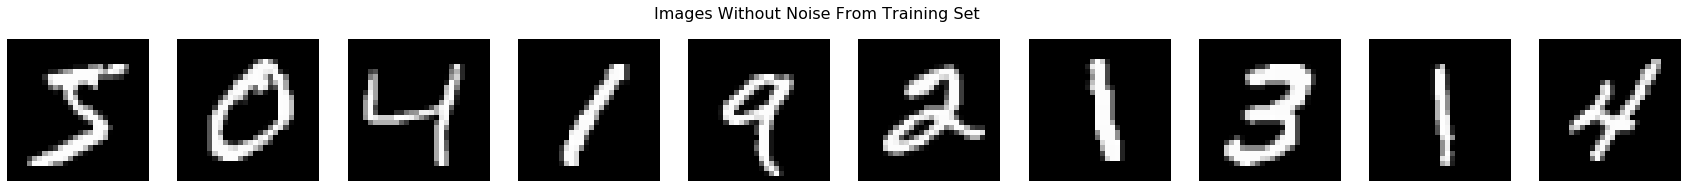

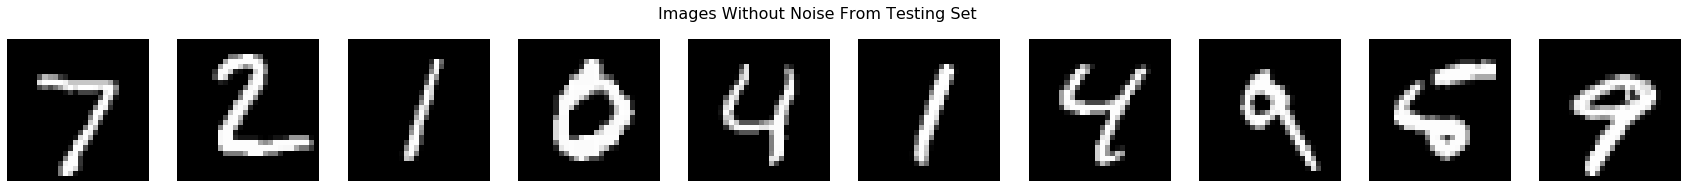

In [11]:
def plot_noise(images, name, noise):
  f = plt.figure(figsize=(30, 3))
  if noise:
    title = "Images With Noise From " + name
  else:
    title = "Images Without Noise From " + name
  f.suptitle(title, fontsize=16)
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis("off")
    plt.imshow(images[i])
    plt.gray()

plot_noise(x_noise, "Training Set", True)
plot_noise(x_noise_test,"Testing Set", True)
plot_noise(x_train, "Training Set", False)
plot_noise(x_test,"Testing Set", False)

In [0]:
x_train = x_train.astype("float32")/255
x_noise = x_noise.astype("float32")/255
x_test = x_test.astype("float32")/255
x_noise_test = x_noise_test.astype("float32")/255

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_noise = x_noise.reshape(x_noise.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_noise_test = x_noise_test.reshape(x_noise_test.shape[0], 28, 28, 1)

Train the autoencoder on the dataset with 100 epochs and batches of 150 images. Use the testing set for validation.

In [13]:
history = autoencoder.fit(x_noise, x_train, epochs=100, batch_size=150, shuffle=True, validation_data=(x_noise_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 11s 184us/sample - loss: 0.2191 - accuracy: 0.7990 - val_loss: 0.1358 - val_accuracy: 0.8060
Epoch 2/100
60000/60000 [==============================] - 4s 63us/sample - loss: 0.1476 - accuracy: 0.8029 - val_loss: 0.1186 - val_accuracy: 0.8087
Epoch 3/100
60000/60000 [==============================] - 4s 64us/sample - loss: 0.1358 - accuracy: 0.8058 - val_loss: 0.1107 - val_accuracy: 0.8110
Epoch 4/100
60000/60000 [==============================] - 4s 63us/sample - loss: 0.1294 - accuracy: 0.8073 - val_loss: 0.1049 - val_accuracy: 0.8108
Epoch 5/100
60000/60000 [==============================] - 4s 63us/sample - loss: 0.1253 - accuracy: 0.8082 - val_loss: 0.1042 - val_accuracy: 0.8120
Epoch 6/100
60000/60000 [==============================] - 4s 63us/sample - loss: 0.1222 - accuracy: 0.8088 - val_loss: 0.1004 - val_accuracy: 0.8122
Epoch 7/100
60000/60000 [=======================

Here, we will save our model.

In [0]:
autoencoder.save("autoencoder.h5")

# **Visualize Results**
We can plot the training loss and accuracy from our model. This will give us an idea of when our model starts to lose effectiveness or overfits.

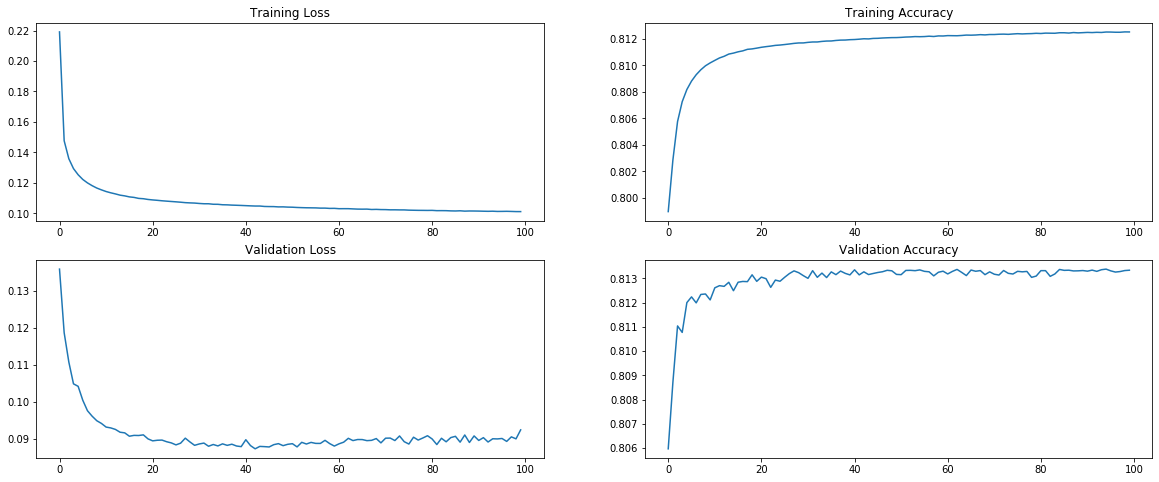

In [21]:
def plot_results(history):
  epochs = range(100)
  keys = ["loss", "accuracy", "val_loss", "val_accuracy"]
  titles = ["Training Loss", "Training Accuracy", "Validation Loss", "Validation Accuracy"]
  f = plt.figure(figsize=(20, 8))
  for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.plot(epochs, history.history[keys[i-1]])
    plt.title(titles[i-1])

plot_results(history)

From what the graphs display, we see that training and validation metrics are quite similar except for some noise in the validation data. It also seems that the model peaks at about 81% accuracy for both training and validation sets. Now that we have graphed the metrics, let's visualize the predictions that are model makes.

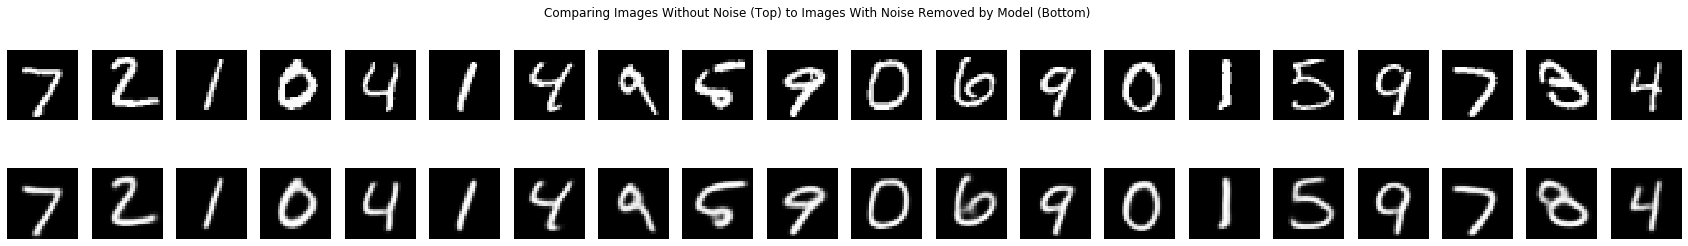

In [14]:
results = autoencoder.predict(x_test[0:20])
f = plt.figure(figsize=(30, 4))
plt.suptitle("Comparing Images Without Noise (Top) to Images With Noise Removed by Model (Bottom)")

for i in range(len(results)):
  plt.subplot(2, len(results), i+1)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.gray()
  plt.axis("off")

  plt.subplot(2, len(results), i+1+len(results))
  plt.imshow(results[i].reshape(28, 28))
  plt.gray()
  plt.axis("off")

Plotting the images allows us to see the usefulness of our data as well. Looking at the test images without noise, we see that some of the digits are not continuous strokes meaning that are model infers a complete digit when there is none. However, most of the data is good and our denoised images from our model reflect that.